# Введение

<b><font size="4">Предсказание коэффициента восстановления золота</font></b>

Заказчик - АО "ЦИФРА".

Задача - подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Цель разработки модели - оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Предоставлены данные с параметрами добычи и очистки.

<b>План по выполнению проекта</b>

1. Подготовьте данные
    1. Открыть файл с данными и изучить общую информацию.
    2. Проверить правильность эффективность обогащения. Вычислить эффективность обогащения на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака. Описать выводы.
    3. Проанализировать признаки, недоступные в тестовой выборке.
    4. Провести предобработку данных.
2. Проанализировать данные
    1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.
    2. Сравнить распределение размеров гранул сырья на обучающей и тестовой выборках. В случае когда распределения сильно отличаются друг от друга, оценка модели будет неправильной.
    3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
3. Построить модель
    1. Написать функцию для вычисления итоговой sMAPE.
    2. Обучить разные модели и оценить их качество кросс-валидацией. Выберать лучшую модель и проверить её на тестовой выборке. Описать выводы.

<b><font size="4">Описание данных</font></b>

Наименование признаков:

<code>[этап].[тип_параметра].[название_параметра]</code>
    
Пример: rougher.input.feed_ag

Возможные значения для блока <code>[этап]</code>:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока <code>[тип_параметра]</code>:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

# Изучение данных

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (mean_absolute_error,
                             make_scorer)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (LinearRegression,
                                  ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

In [ ]:
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)

In [ ]:
RANDOM_STATE = 12345

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')

In [ ]:
display(df.head())
display(df_train.head())
display(df_test.head())

print(df.shape, df_train.shape, df_test.shape)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
1,2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819
2,2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623
3,2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710
4,2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.456,-399.051,1248.699,-400.877,1058.839,-398.988,949.645,-399.278,24.887,-499.357,14.979,-500.187,19.962,-450.639,14.009,-450.022,12.025,-500.786,8.

(19439, 87) (14149, 87) (5290, 53)


In [ ]:
df.info()
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Отметим нулевые объекты и разное количество признаков в таблицах.

# Подготовка данных

## Проверка правильности расчета эффективности обогащения

Рассчитаем признак <code>rougher.output.recovery</code>

Формула по который производится расчёт.

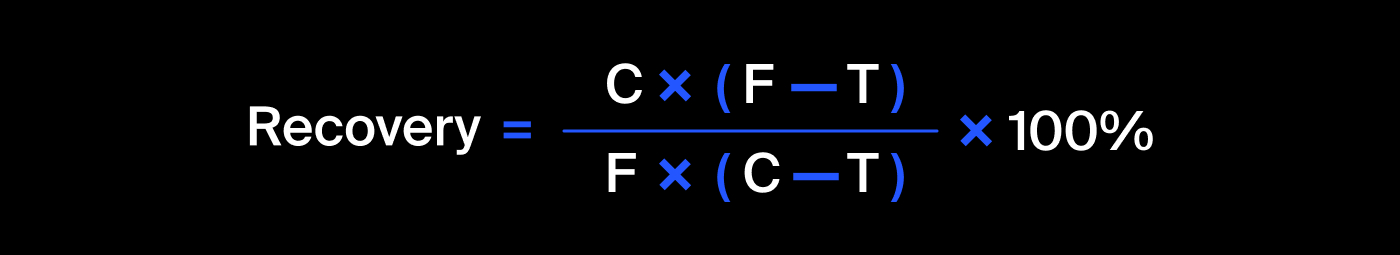

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Будем работать с полным датасетом.

In [ ]:
df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

Функция для подсчета <code>rougher.output.recovery</code>

In [ ]:
def recovery_calc(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    return recovery

In [ ]:
recovery_calculated = df.apply(recovery_calc, axis=1)
recovery_calculated.head()

0   87.108
1   86.843
2   86.842
3   87.226
4   86.689
dtype: float64

Рассчитаем MAE.

In [ ]:
print(f'MAE между признаком в датасете и рассчитанным по формуле: {mean_absolute_error(df["rougher.output.recovery"], recovery_calculated):.2e}')

MAE между признаком в датасете и рассчитанным по формуле: 9.87e-15


<b>MAE очень близка к 0.</b>

## Анализ признаков отсутствующих в тестовой выборке

Предварительно добавим в df_test целевые признаки из df по совпадению даты.

In [ ]:
df = df.set_index('date')
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

display(df.head())
display(df_train.head())
display(df_test.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819
2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623
2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710
2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.456,-399.051,1248.699,-400.877,1058.839,-398.988,949.645,-399.278,24.887,-499.357,14.979,-500.187,19.962,-

In [ ]:
df_test = df_test.join(other=[df['rougher.output.recovery'], df['final.output.recovery']])
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709,89.993,70.274
2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819,88.090,68.910
2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623,88.413,68.143
2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710,87.360,67.776
2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.45

Посмотрим на признаки в обеих таблицах.

In [ ]:
columns_train = df_train.columns.to_list()
columns_test = df_test.columns.to_list()

Посмотрим каких признаков нет в таблице для обучения.

In [ ]:
train_test_difference = [x for x in columns_train if x not in columns_test]
train_test_difference

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

In [ ]:
df_train[train_test_difference].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,10.412,0.895,16.904,2.143,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,41885.707,3481.779,3520.337,2.839,11.501,7.101,28.029,19.794,5.008,0.509,19.154,1.170,14.500,4.695,8.765,2.606
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,10.463,0.927,16.635,2.225,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,42050.862,3498.371,3489.982,2.859,11.616,7.279,28.067,20.051,4.955,0.537,18.965,1.185,14.265,4.593,9.001,2.488
2016-01-15 02:00:00,6.056,10.214,5.384,42.658,10.507,0.954,16.209,2.258,8.604,10.354,19.168,33.969,16.492,3.125,6.472,2.417,42018.101,3495.349,3502.360,2.946,11.696,7.217,27.454,19.737,4.843,0.546,18.809,1.163,14.116,4.625,8.843,2.458
2016-01-15 03:00:00,6.048,9.977,4.859,42.690,10.423,0.884,16.533,2.147,7.222,8.497,15.979,28.261,16.024,2.960,6.844,2.262,42029.448,3498.578,3499.163,3.002,11.915,7.176,27.341,19.321,4.655,0.543,19.330,1.080,13.732,4.482,9.123,2.322
2016-01-15 04:00:00,6.149,10.143,4.939,42.774,10.360,0.793,16.526,2.055,9.089,9.987,19.200,33.045,16.480,3.112,6.550,2.277,42125.354,3494.801,3506.679,3.170,12.411,7.240,27.041,19.216,4.553,0.515,19.267,1.013,14.080,4.471,8.871,2.330


В датасете для теста отсутствуют следующий признаки:
1. Признаки типа <code>output</code> характеризующие параметры сырья после окончания технологического этапа;
2. Признаки типа <code>calculation</code> относящиеся к расчётным характеристикам.

Признаки <code>output</code> - являются признаками продукта, получаемого на каждом этапе, и сильно кореллируют с финальным продуктом. Т.к. невозможно повлиять на них напрямую и оценить до начала процесса обогащения, такие признаки не подходят для обучения модели.

Признаки <code>calculation</code> - это расчетные признаки на этапе флотации. Исключим их из обучения модели.

Скорректируем датасет для обучения.

In [ ]:
df_train_upd = df_train.drop(train_test_difference, axis=1)
display(df_train_upd.head())
print(df_train_upd.shape)

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,70.541,127.092,10.128,7.250,0.989,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,87.108,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
2016-01-15 01:00:00,69.266,125.629,10.296,7.250,1.003,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,86.843,1000.286,-400.065,1600.755,-449.953,1600.480,-449.831,1600.528,-449.954,1399.227,-450.870,1399.720,-450.119,25.881,-499.990,23.890,-500.372,23.971,-500.085,22.086,-499.447,13.992,-505.503,11.951,-501.332,10.039,-500.170,7.985,-500.582,13.998,-599.787
2016-01-15 02:00:00,68.116,123.820,11.316,7.250,0.991,1601.556,-499.998,1600.387,-500.608,1602.004,-500.870,1599.542,-499.827,6.116,2.160,530.027,57.511,35.972,6.362,11.921,6.197,11.920,6.205,86.842,999.720,-400.074,1599.337,-450.009,1599.673,-449.954,1599.849,-449.954,1399.181,-449.938,1400.317,-450.527,26.005,-499.930,23.887,-499.952,23.914,-499.442,23.958,-499.902,14.015,-502.521,11.913,-501.133,10.071,-500.129,8.014,-500.518,14.029,-601.427
2016-01-15 03:00:00,68.348,122.270,11.322,7.250,0.997,1599.969,-500.952,1600.659,-499.677,1600.304,-500.728,1600.450,-500.053,6.043,2.038,542.590,57.793,36.862,6.118,11.630,6.203,11.692,6.197,87.226,999.815,-400.200,1600.059,-450.620,1600.013,-449.910,1597.725,-450.130,1400.943,-450.030,1400.235,-449.791,25.943,-499.177,23.956,-499.849,23.967,-500.009,23.954,-499.945,14.037,-500.857,12.000,-501.194,9.970,-499.202,7.977,-500.256,14.006,-599.996
2016-01-15 04:00:00,66.927,117.988,11.914,7.250,1.010,1601.340,-498.975,1601.438,-500.323,1599.582,-500.888,1602.650,-500.593,6.061,1.787,540.532,56.047,34.348,5.664,10.958,6.199,10.961,6.195,86.689,999.679,-399.753,1600.209,-

(14149, 54)


## Предобработка данных

### Проверка дубликатов

In [ ]:
print(df_train_upd.duplicated().sum())
print(df_test.duplicated().sum())

0
0


Дубликатов нет.

### Отбор признаков

Если существуют признаки сильно кореллирующие один с другим, оставим только один из этих признаков для упрощения модели.

#### Обучающая выборка

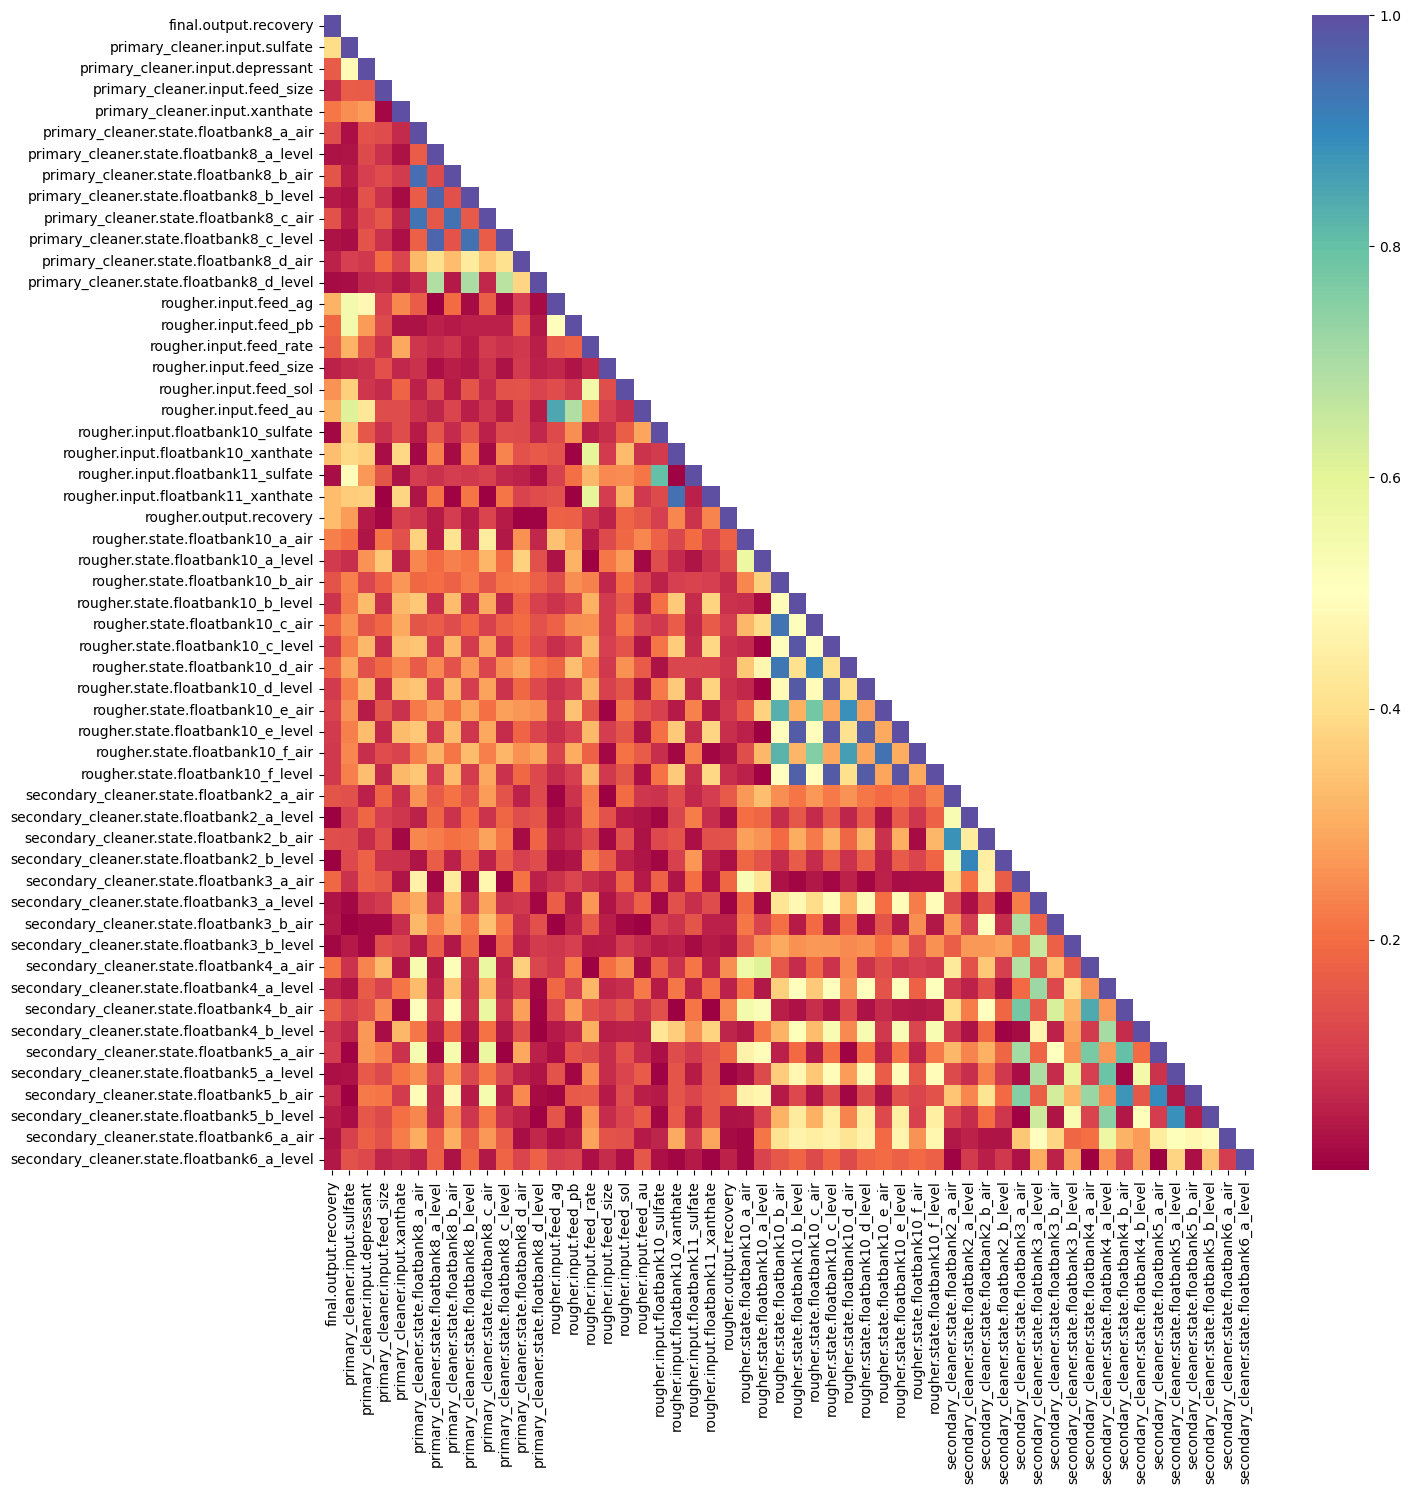

In [ ]:
df_train_upd_corr = df_train_upd.corr().abs()
df_train_upd_corr_l = df_train_upd_corr.where(np.tril(np.ones(df_train_upd_corr.shape)).astype('bool'))

plt.figure(figsize=(15, 15))
sns.heatmap(df_train_upd_corr_l, cmap="Spectral")
plt.show()

Посмотрим на признаки с корелляцией больше 0.8.

Проверим нет ли признаков с корелляцией равной 1.

In [ ]:
df_train_upd_corr_l[df_train_upd_corr_l == 1].sum().count() == pd.Series(df_train_upd_corr_l.columns).count()

True

Корреляция равная 1 только между самими признаками.

Напишем функцию для сведения в отедльную табличку признаков с корреляцией выше опредленного порога.

In [ ]:
def corr_filter(df_corr, bound):
    df_filtered = df_corr[(df_corr >= bound) & (df_corr !=1.000)]
    df_flattened = df_filtered.unstack().sort_values().drop_duplicates().dropna()
    df_flattened = pd.DataFrame(df_flattened).reset_index()
    df_flattened.columns = ['feature_1', 'feature_2', 'corr_coefficient']
    return df_flattened

In [ ]:
train_best_corr = corr_filter(df_train_upd_corr_l, 0.8).groupby('feature_1', as_index=False).max()
train_best_corr

,feature_1,feature_2,corr_coefficient
0,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_c_air,0.945
1,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_c_level,0.959
2,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_c_air,0.940
3,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_level,0.938
4,rougher.input.feed_ag,rougher.input.feed_au,0.846
5,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.804
6,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,0.940
7,rougher.state.floatbank10_b_air,rougher.state.floatbank10_f_air,0.937
8,rougher.state.floatbank10_b_level,rougher.state.floatbank10_f_level,0.988
9,rougher.state.floatbank10_c_air,rougher.state.floatbank10_d_air,0.913


Напишем функцию возвращающую название столбца из двух в котором меньше пропусков.

In [ ]:
def corr_na_comparison_to_drop(row, df):
    if df[row.iat[0]].isna().sum() <= df[row.iat[1]].isna().sum():
        return row.iat[1]
    else: return row.iat[0]

In [ ]:
columns_train_to_drop = train_best_corr.apply(corr_na_comparison_to_drop, axis=1, df=df_train_upd).unique().tolist()
columns_train_to_drop

['primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_b_air',
 'rougher.input.feed_au',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.state.floatbank10_e_air',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank5_b_air',
 'secondary_cleaner.state.floatbank5_b_level']

Отбросим признаки.

In [ ]:
print(df_train_upd.shape)
print(len(columns_train_to_drop))
df_train_upd = df_train_upd.drop(columns_train_to_drop, axis=1)
print(df_train_upd.shape)

(14149, 54)
18
(14149, 36)


#### Тестовая выборка

Для тестовой выборки нужно удалить те же признаки что и для обучающей.

Отбросим признаки.

In [ ]:
print(df_test.shape)
print(len(columns_train_to_drop))
df_test = df_test.drop(columns_train_to_drop, axis=1)
print(df_test.shape)

(5290, 54)
18
(5290, 36)


### Обработка пропусков

#### Обучающая выборка

In [ ]:
train_na_columns = df_train_upd.isna().sum()
train_na_columns

final.output.recovery                           0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank10_xanthate              8
rougher.output.recovery                         0
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1


Смотреть подробно признаки у которых мало пропусков не целесообразно. Рассмотрим только признаки где пропусков более 100. Остальные строки с пропусками позднее удалим.

Отсортируем признаки на два списка (0, 100) и [100, inf).

In [ ]:
na_train_to_drop = train_na_columns[train_na_columns.between(1, 99, inclusive='both')].index.to_list()
na_train_to_study = train_na_columns[train_na_columns >= 100].index.to_list()

print(na_train_to_drop)
print('')
print(na_train_to_study)

['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_rate', 'rougher.input.feed_sol', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner

Рассмотрим признаки для дальнейшего изучения.

In [ ]:
na_train_to_study

['primary_cleaner.input.xanthate',
 'rougher.input.feed_pb',
 'rougher.input.feed_size']

Напишем функцию для изучения признаков с пропусками.

In [ ]:
def na_test(df, column_list):
    for column in column_list:
        print('Название признака:', column)
        print('Относительное отклонение от среднего в процентах:', round(((df[column].mad() / df[column].mean()) * 100), 2))
        print('Процент пропущенных значений от всех:', (df[column].isna().sum() / df[column].count()) * 100)
        print('')
        print('')

In [ ]:
na_test(df_train_upd, na_train_to_study)

Название признака: primary_cleaner.input.xanthate
Относительное отклонение от среднего в процентах: 33.13
Процент пропущенных значений от всех: 0.7117944337675279


Название признака: rougher.input.feed_pb
Относительное отклонение от среднего в процентах: 24.39
Процент пропущенных значений от всех: 0.7117944337675279


Название признака: rougher.input.feed_size
Относительное отклонение от среднего в процентах: 20.71
Процент пропущенных значений от всех: 1.0282042127811495




<ipython-input-30-617de7effbf3>:4: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  print('Относительное отклонение от среднего в процентах:', round(((df[column].mad() / df[column].mean()) * 100), 2))


У признаков <code>['primary_cleaner.input.xanthate', 'rougher.input.feed_pb', 'rougher.input.feed_size']</code> заполним пропуски ближайшим предыдущим значением по столбцу.

<b>Удалим пропуски и заполним значения.</b>

In [ ]:
df_train_upd = df_train_upd.dropna(subset=na_train_to_drop)
df_train_upd.isna().sum()[df_train_upd.isna().sum() > 0]

primary_cleaner.input.xanthate     86
rougher.input.feed_pb              95
rougher.input.feed_size           139
dtype: int64

In [ ]:
for column in na_train_to_study:
    df_train_upd[column] = (df_train_upd[column].fillna(method='ffill'))
df_train_upd.isna().sum()

final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.output.recovery                       0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_d_air         

#### Тестовая выборка

In [ ]:
test_na_columns = df_test.isna().sum()
test_na_columns

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.state.floatbank10_a_air                0
rougher.state.floatbank10_a_level              0
rougher.state.floatbank10_d_air                0
rougher.state.floatbank10_d_level              0
rougher.state.floatb

In [ ]:
na_test_to_drop = test_na_columns[test_na_columns.between(1, 20, inclusive='both')].index.to_list()
na_test_to_drop

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.xanthate',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank3_a_air']

Рассмотрим отдельно признак <code>rougher.input.feed_sol</code>.

In [ ]:
na_test(df_test, ['rougher.input.feed_sol'])

Название признака: rougher.input.feed_sol
Относительное отклонение от среднего в процентах: 11.3
Процент пропущенных значений от всех: 0.39855760106282023




<ipython-input-30-617de7effbf3>:4: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  print('Относительное отклонение от среднего в процентах:', round(((df[column].mad() / df[column].mean()) * 100), 2))


Заполним пропуски ближайшим предыдущим значением по столбцу.

<b>Удалим пропуски и заполним значения.</b>

In [ ]:
df_test = df_test.dropna(subset=na_test_to_drop)
df_test.isna().sum()[df_test.isna().sum() > 0]

rougher.input.feed_sol    18
dtype: int64

In [ ]:
df_test['rougher.input.feed_sol'] = (df_test['rougher.input.feed_sol'].fillna(method='ffill'))
df_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_level       

# Анализ данных

## Изменение концентрация Au, Ag, Pb на разных стадиях очистки

Рассмотрим полный датасет.

In [ ]:
df.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

Выделим столбцы с контентрацией металлов Au, Ag, Pb.

In [ ]:
df_columns = df.columns.to_list()
metall_conc = ['concentrate_ag', 'concentrate_pb', 'concentrate_au', 'concentrate_sol', 'feed_au', 'feed_ag', 'feed_pb', 'feed_sol']
df_columns_conc = []

for column in df_columns:
    if any(substring in column for substring in metall_conc):
        df_columns_conc.append(column)

df_columns_conc

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [ ]:
df_metall_conc = df[df_columns_conc]
df_metall_conc.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
date,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,8.548,10.390,19.529,34.174,6.100,2.285,36.809,6.486,11.501,7.101,28.029,19.794
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,8.559,10.497,19.369,34.119,6.161,2.266,35.753,6.479,11.616,7.279,28.067,20.051
2016-01-15 02:00:00,6.056,10.214,5.384,42.658,8.604,10.354,19.168,33.969,6.116,2.160,35.972,6.362,11.696,7.217,27.454,19.737
2016-01-15 03:00:00,6.048,9.977,4.859,42.690,7.222,8.497,15.979,28.261,6.043,2.038,36.862,6.118,11.915,7.176,27.341,19.321
2016-01-15 04:00:00,6.149,10.143,4.939,42.774,9.089,9.987,19.200,33.045,6.061,1.787,34.348,5.664,12.411,7.240,27.041,19.216


### Изменение концентрация золота

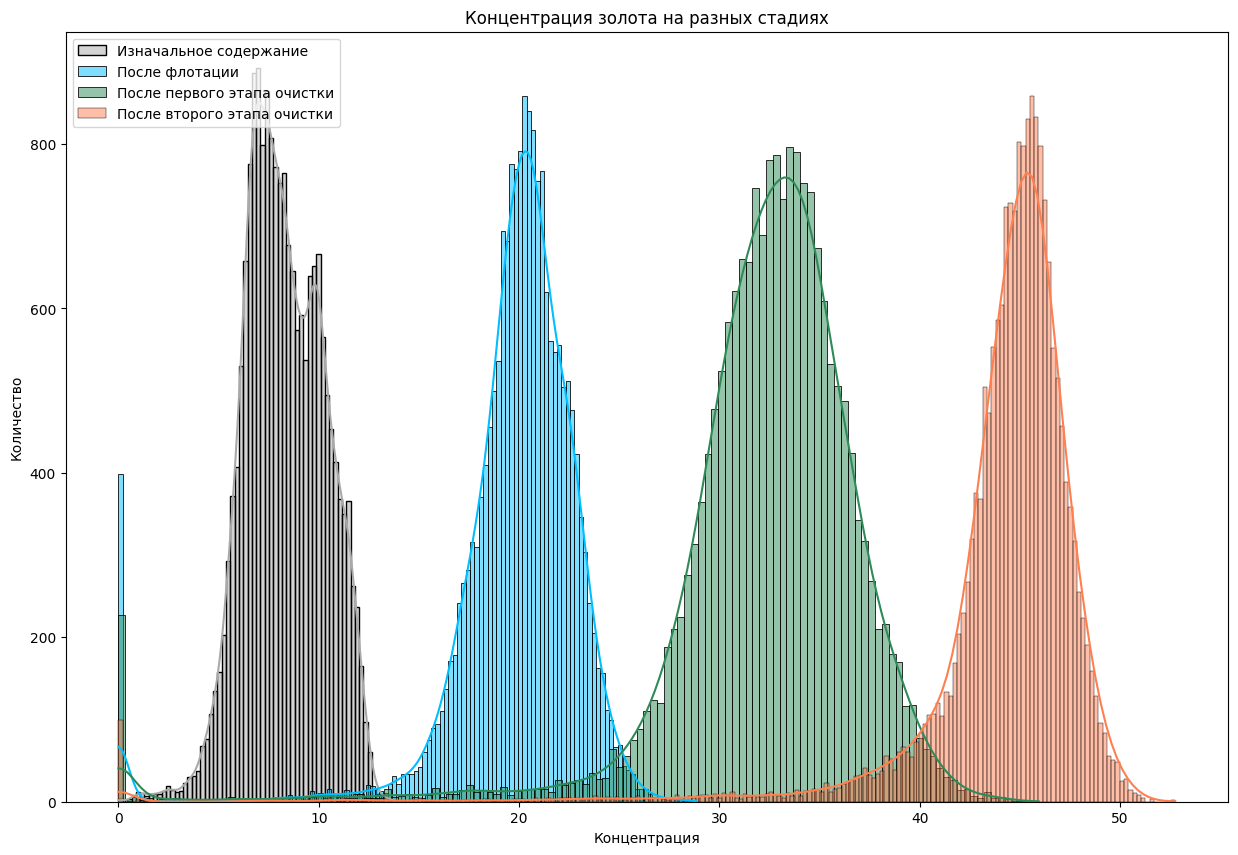

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_metall_conc, x='rougher.input.feed_au', kde=True, color='darkgray', label='Изначальное содержание').
 set(title=('Концентрация золота на разных стадиях'), xlabel='Концентрация', ylabel='Количество'))
sns.histplot(data=df_metall_conc, x='rougher.output.concentrate_au', kde=True, color='deepskyblue', label='После флотации')
sns.histplot(data=df_metall_conc, x='primary_cleaner.output.concentrate_au', kde=True, color='seagreen',
             label='После первого этапа очистки')
sns.histplot(data=df_metall_conc, x='final.output.concentrate_au', kde=True, color='coral', label='После второго этапа очистки')

plt.legend(loc='upper left')
plt.show()

1. Существует аномальные выбросы концентраций на этапах после начала процесса, около 0.
2. Концентрация возрастает после каждого этапа.
3. Максимальная концентрация достигает после второго этапа очистки.

### Изменение концентрация серебра

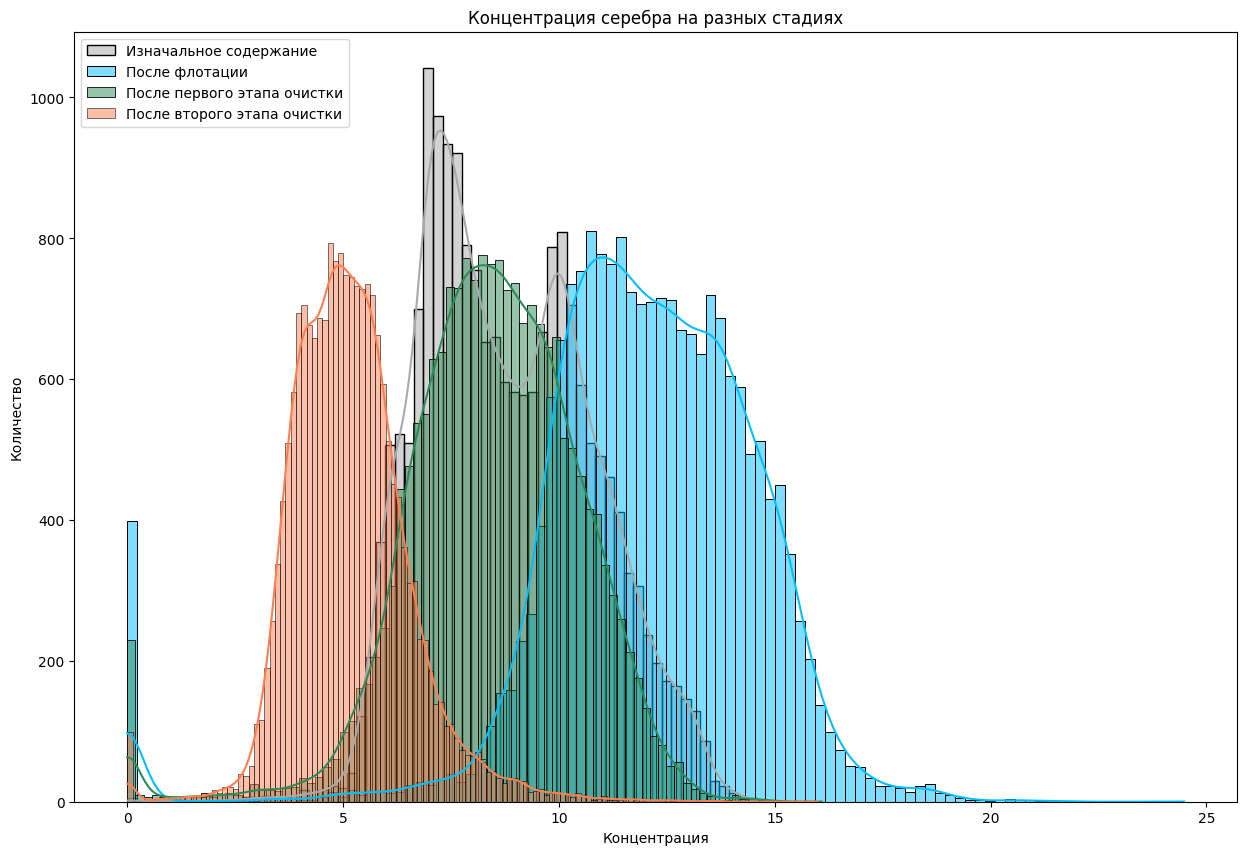

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_metall_conc, x='rougher.input.feed_ag', kde=True, color='darkgray', label='Изначальное содержание').
 set(title=('Концентрация серебра на разных стадиях'), xlabel='Концентрация', ylabel='Количество'))
sns.histplot(data=df_metall_conc, x='rougher.output.concentrate_ag', kde=True, color='deepskyblue', label='После флотации')
sns.histplot(data=df_metall_conc, x='primary_cleaner.output.concentrate_ag', kde=True, color='seagreen',
             label='После первого этапа очистки')
sns.histplot(data=df_metall_conc, x='final.output.concentrate_ag', kde=True, color='coral', label='После второго этапа очистки')

plt.legend(loc='upper left')
plt.show()

1. Существует аномальные выбросы концентраций на этапах после начала процесса, около 0.
2. Концентрация увеличивается после флотации и уменьшается на дальнейших этапах.
3. Минимальная концентрация достигает после второго этапа очистки.

### Изменение концентрация свинца

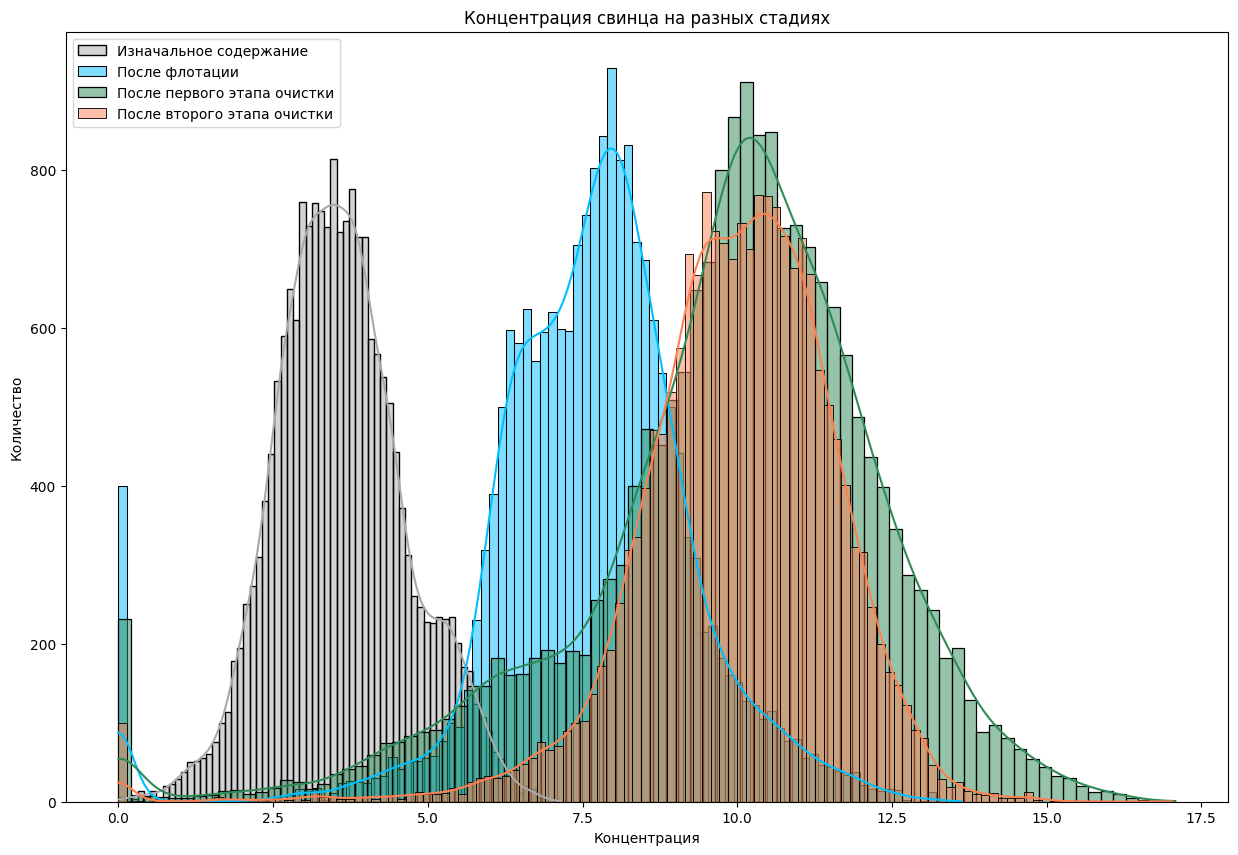

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_metall_conc, x='rougher.input.feed_pb', kde=True, color='darkgray', label='Изначальное содержание').
 set(title=('Концентрация свинца на разных стадиях'), xlabel='Концентрация', ylabel='Количество'))
sns.histplot(data=df_metall_conc, x='rougher.output.concentrate_pb', kde=True, color='deepskyblue', label='После флотации')
sns.histplot(data=df_metall_conc, x='primary_cleaner.output.concentrate_pb', kde=True, color='seagreen',
             label='После первого этапа очистки')
sns.histplot(data=df_metall_conc, x='final.output.concentrate_pb', kde=True, color='coral', label='После второго этапа очистки')

plt.legend(loc='upper left')
plt.show()

1. Существует аномальные выбросы концентраций на всех этапов около 0.
2. Концентрация увеличивается после флотации и первого этапа очистки и остается почти неизменным после второго этапа очистки.

### Изменение средних концентраций металлов

In [ ]:
df_metall_conc.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
date,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,8.548,10.390,19.529,34.174,6.100,2.285,36.809,6.486,11.501,7.101,28.029,19.794
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,8.559,10.497,19.369,34.119,6.161,2.266,35.753,6.479,11.616,7.279,28.067,20.051
2016-01-15 02:00:00,6.056,10.214,5.384,42.658,8.604,10.354,19.168,33.969,6.116,2.160,35.972,6.362,11.696,7.217,27.454,19.737
2016-01-15 03:00:00,6.048,9.977,4.859,42.690,7.222,8.497,15.979,28.261,6.043,2.038,36.862,6.118,11.915,7.176,27.341,19.321
2016-01-15 04:00:00,6.149,10.143,4.939,42.774,9.089,9.987,19.200,33.045,6.061,1.787,34.348,5.664,12.411,7.240,27.041,19.216


In [ ]:
index = pd.Series(['Изначальное содержание',
                   'После флотации',
                   'После первого этапа очистки',
                   'После второго этапа очистки']).rename('stages')
au = pd.Series([df['rougher.input.feed_au'].mean(),
      df['rougher.output.concentrate_au'].mean(),
      df['primary_cleaner.output.concentrate_au'].mean(),
      df['final.output.concentrate_au'].mean()]).rename('au')
ag = pd.Series([df['rougher.input.feed_ag'].mean(),
      df['rougher.output.concentrate_ag'].mean(),
      df['primary_cleaner.output.concentrate_ag'].mean(),
      df['final.output.concentrate_ag'].mean()]).rename('ag')
pb = pd.Series([df['rougher.input.feed_pb'].mean(),
      df['rougher.output.concentrate_pb'].mean(),
      df['primary_cleaner.output.concentrate_pb'].mean(),
      df['final.output.concentrate_pb'].mean()]).rename('pb')

df_metall_conc_mean = pd.concat([index, au, ag, pb], axis=1)

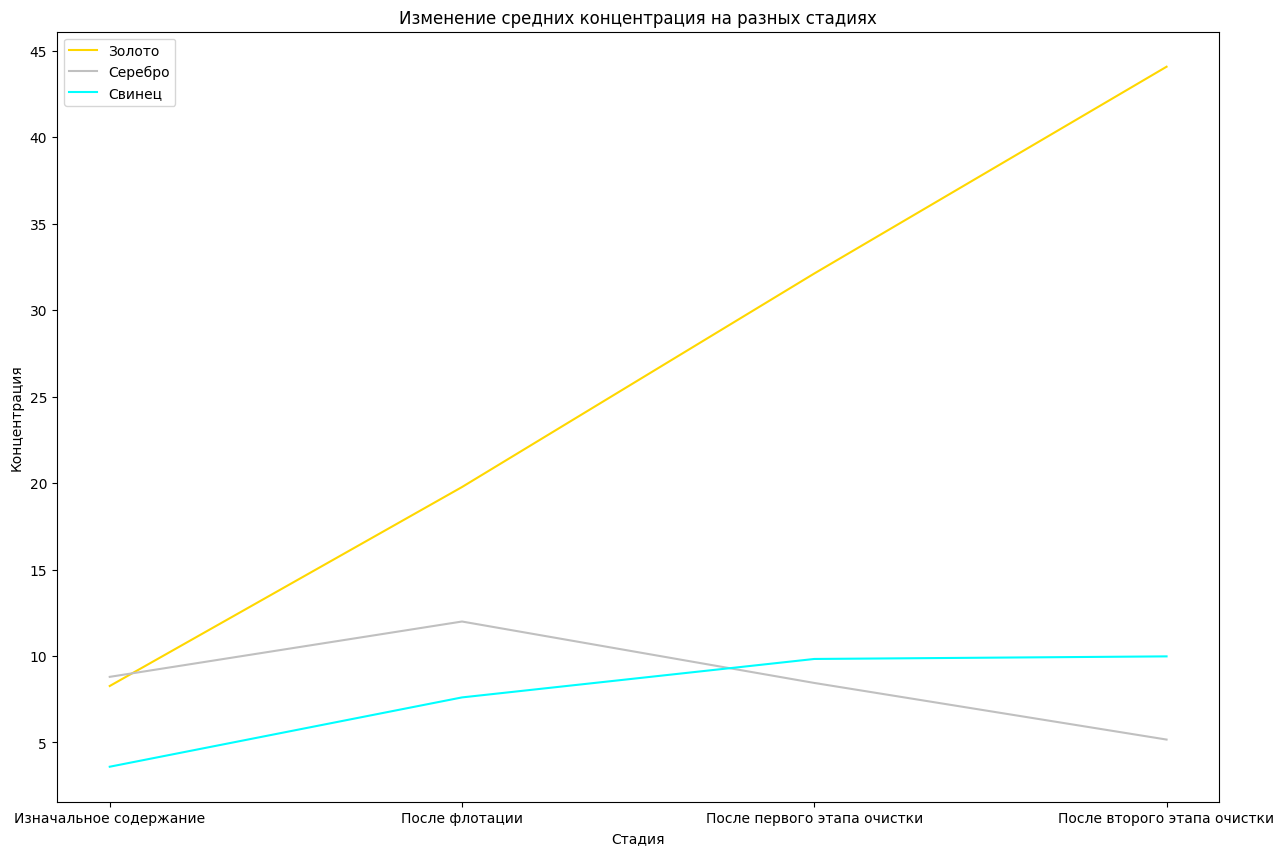

In [ ]:
plt.figure(figsize=(15, 10))

(sns.lineplot(data=df_metall_conc_mean, x='stages', y='au', color='gold', label='Золото').
 set(title=('Изменение средних концентрация на разных стадиях'), xlabel='Стадия', ylabel='Концентрация'))
sns.lineplot(data=df_metall_conc_mean, x='stages', y='ag', color='silver', label='Серебро')
sns.lineplot(data=df_metall_conc_mean, x='stages', y='pb', color='cyan', label='Свинец')

plt.legend(loc='upper left')
plt.show()

1. Для всех исследованных металлов есть аномальные значения концентрации около 0.
2. Концентрация золото возрастает на протяжении всего технологического процесса.
3. Концентрация серебра возрастает после флотации и падает в дальнейшем.
4. Концентрация свинца возрастает до второго этапа очистки и практически не изменяется после него.

## Распределение размеров гранул сырья

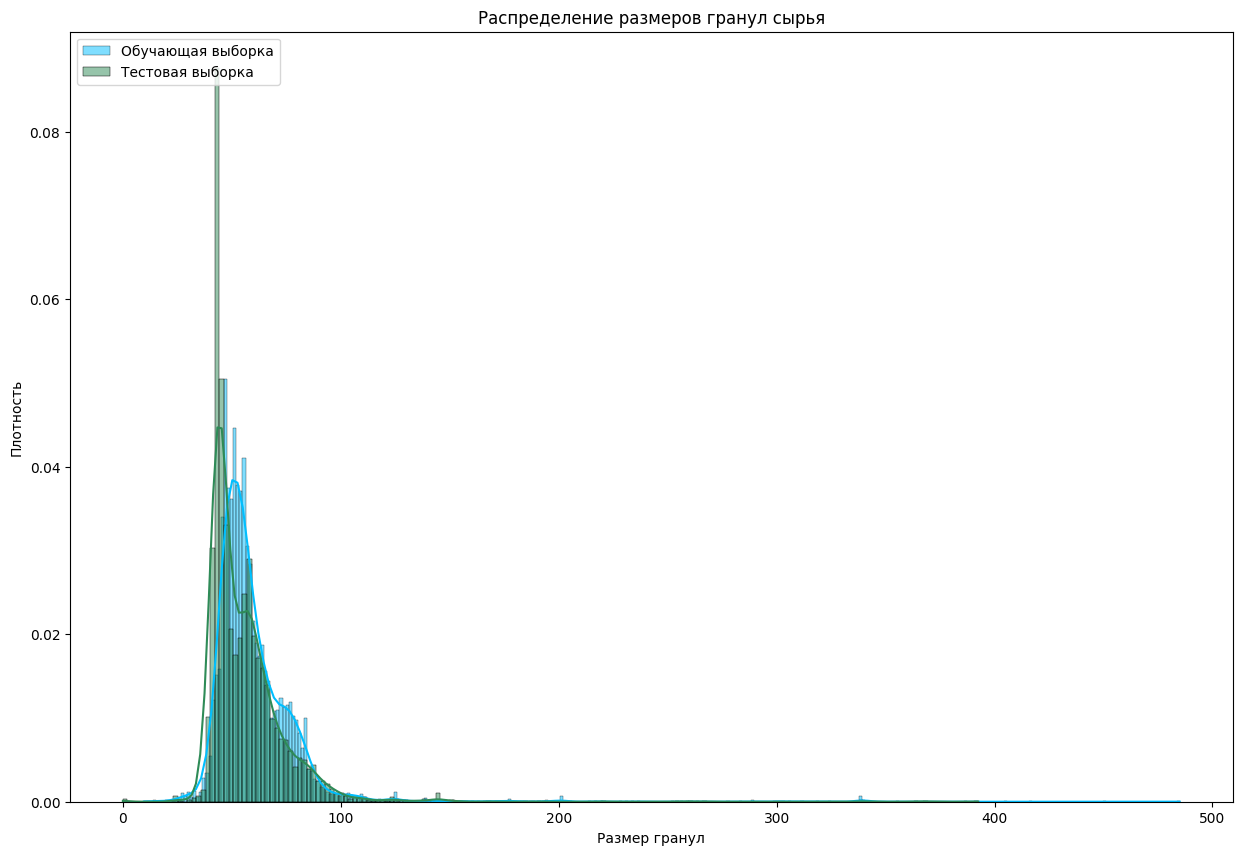

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_train_upd, x='rougher.input.feed_size', kde=True, stat="density", color='deepskyblue', label='Обучающая выборка').
 set(title=('Распределение размеров гранул сырья'), xlabel='Размер гранул', ylabel='Плотность'))
sns.histplot(data=df_test, x='rougher.input.feed_size', kde=True, stat="density", color='seagreen', label='Тестовая выборка')
plt.legend(loc='upper left')
plt.show()

В обоих выборках присутсвует много выбросов после размера гранул выше 110, настроим лимиты графиков.

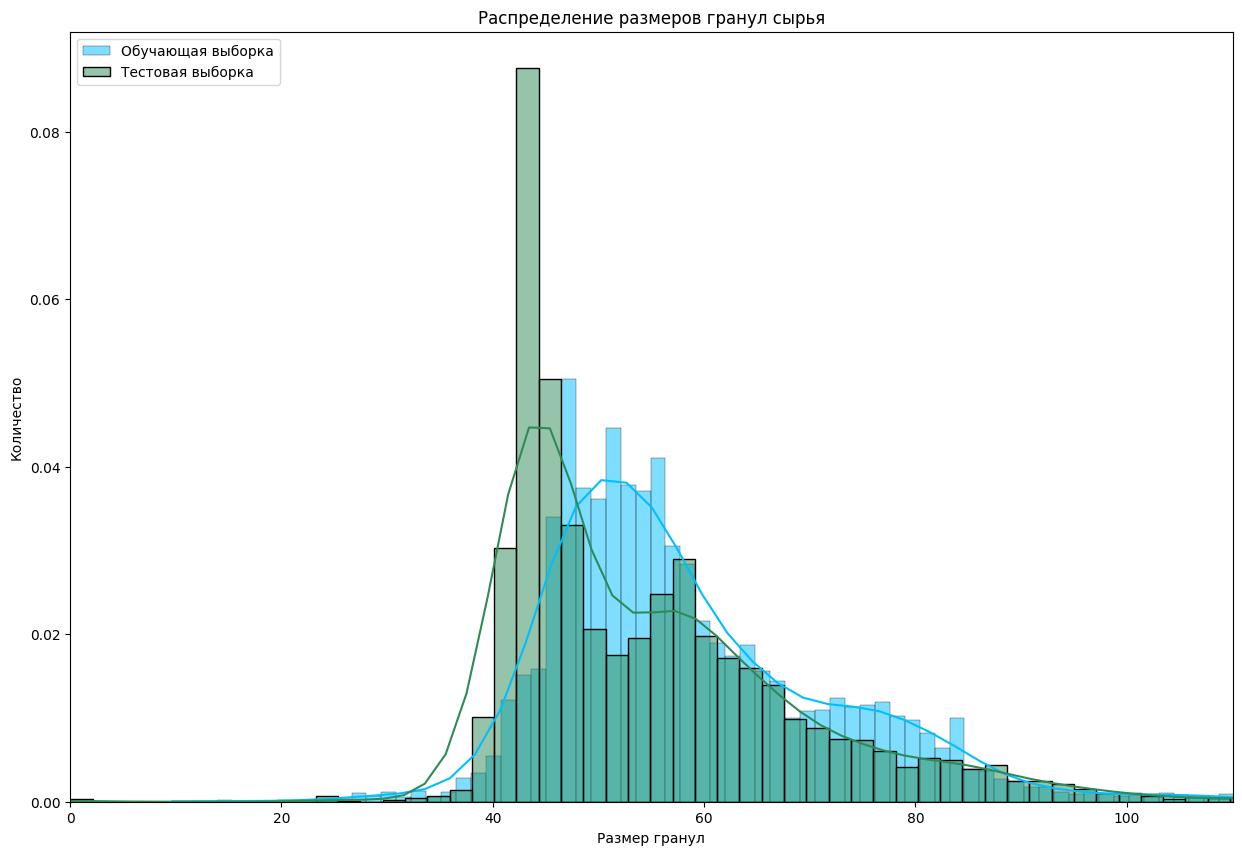

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_train_upd, x='rougher.input.feed_size', kde=True, stat="density", color='deepskyblue', label='Обучающая выборка').
 set(title=('Распределение размеров гранул сырья'), xlabel='Размер гранул', ylabel='Количество', xlim=(0, 110)))
sns.histplot(data=df_test, x='rougher.input.feed_size', kde=True, stat="density", color='seagreen', label='Тестовая выборка')

plt.legend(loc='upper left')
plt.show()

Распределения схожи, распределение размеров гранул тестовый выборки сильнее смещено влево. Можем использовать для построения модели.

## Исследование суммарной концентрации всех веществ на разных стадиях

In [ ]:
df_metall_conc.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
date,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,8.548,10.390,19.529,34.174,6.100,2.285,36.809,6.486,11.501,7.101,28.029,19.794
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,8.559,10.497,19.369,34.119,6.161,2.266,35.753,6.479,11.616,7.279,28.067,20.051
2016-01-15 02:00:00,6.056,10.214,5.384,42.658,8.604,10.354,19.168,33.969,6.116,2.160,35.972,6.362,11.696,7.217,27.454,19.737
2016-01-15 03:00:00,6.048,9.977,4.859,42.690,7.222,8.497,15.979,28.261,6.043,2.038,36.862,6.118,11.915,7.176,27.341,19.321
2016-01-15 04:00:00,6.149,10.143,4.939,42.774,9.089,9.987,19.200,33.045,6.061,1.787,34.348,5.664,12.411,7.240,27.041,19.216


In [ ]:
df_metall_conc['sum_feed'] = (df_metall_conc['rougher.input.feed_au'] +
                              df_metall_conc['rougher.input.feed_ag'] +
                              df_metall_conc['rougher.input.feed_pb'] +
                              df_metall_conc['rougher.input.feed_sol'])
df_metall_conc['sum_rougher'] = (df_metall_conc['rougher.output.concentrate_au'] +
                              df_metall_conc['rougher.output.concentrate_ag'] +
                              df_metall_conc['rougher.output.concentrate_pb'] +
                              df_metall_conc['rougher.output.concentrate_sol'])
df_metall_conc['sum_first_cleaner'] = (df_metall_conc['primary_cleaner.output.concentrate_au'] +
                              df_metall_conc['primary_cleaner.output.concentrate_ag'] +
                              df_metall_conc['primary_cleaner.output.concentrate_pb'] +
                              df_metall_conc['primary_cleaner.output.concentrate_sol'])
df_metall_conc['sum_final'] = (df_metall_conc['final.output.concentrate_au'] +
                              df_metall_conc['final.output.concentrate_ag'] +
                              df_metall_conc['final.output.concentrate_pb'] +
                              df_metall_conc['final.output.concentrate_sol'])
df_metall_conc.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,sum_feed,sum_rougher,sum_first_cleaner,sum_final
date,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,8.548,10.390,19.529,34.174,6.100,2.285,36.809,6.486,11.501,7.101,28.029,19.794,51.680,66.425,72.641,63.644
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,8.559,10.497,19.369,34.119,6.161,2.266,35.753,6.479,11.616,7.279,28.067,20.051,50.659,67.013,72.543,63.958
2016-01-15 02:00:00,6.056,10.214,5.384,42.658,8.604,10.354,19.168,33.969,6.116,2.160,35.972,6.362,11.696,7.217,27.454,19.737,50.610,66.104,72.095,64.311
2016-01-15 03:00:00,6.048,9.977,4.859,42.690,7.222,8.497,15.979,28.261,6.043,2.038,36.862,6.118,11.915,7.176,27.341,19.321,51.062,65.753,59.958,63.573
2016-01-15 04:00:00,6.149,10.143,4.939,42.774,9.089,9.987,19.200,33.045,6.061,1.787,34.348,5.664,12.411,7.240,27.041,19.216,47.859,65.908,71.321,64.005


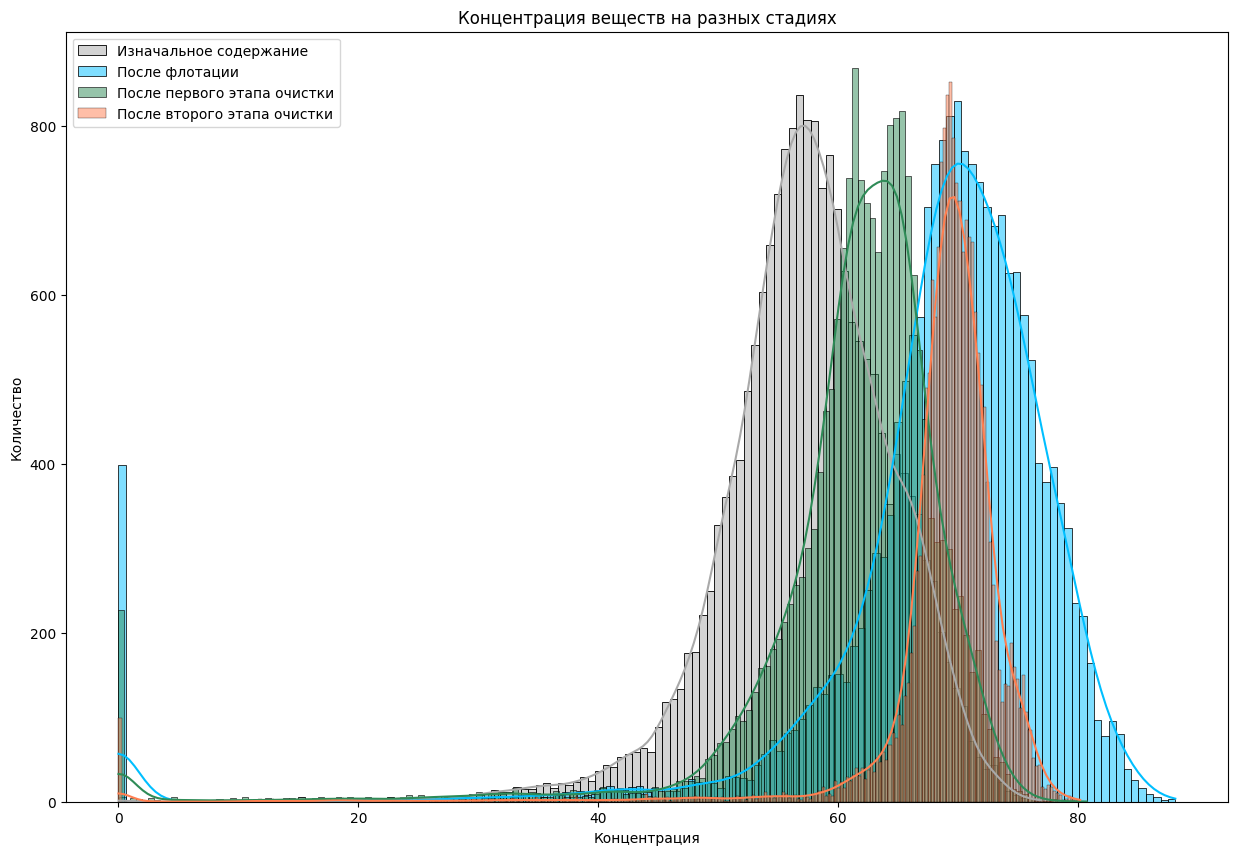

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_metall_conc, x='sum_feed', kde=True, color='darkgray', label='Изначальное содержание').
 set(title=('Концентрация веществ на разных стадиях'), xlabel='Концентрация', ylabel='Количество'))
sns.histplot(data=df_metall_conc, x='sum_rougher', kde=True, color='deepskyblue', label='После флотации')
sns.histplot(data=df_metall_conc, x='sum_first_cleaner', kde=True, color='seagreen',
             label='После первого этапа очистки')
sns.histplot(data=df_metall_conc, x='sum_final', kde=True, color='coral', label='После второго этапа очистки')

plt.legend(loc='upper left')
plt.show()

Заметим большое количество аномалий около 0, приблизим гистограмму.

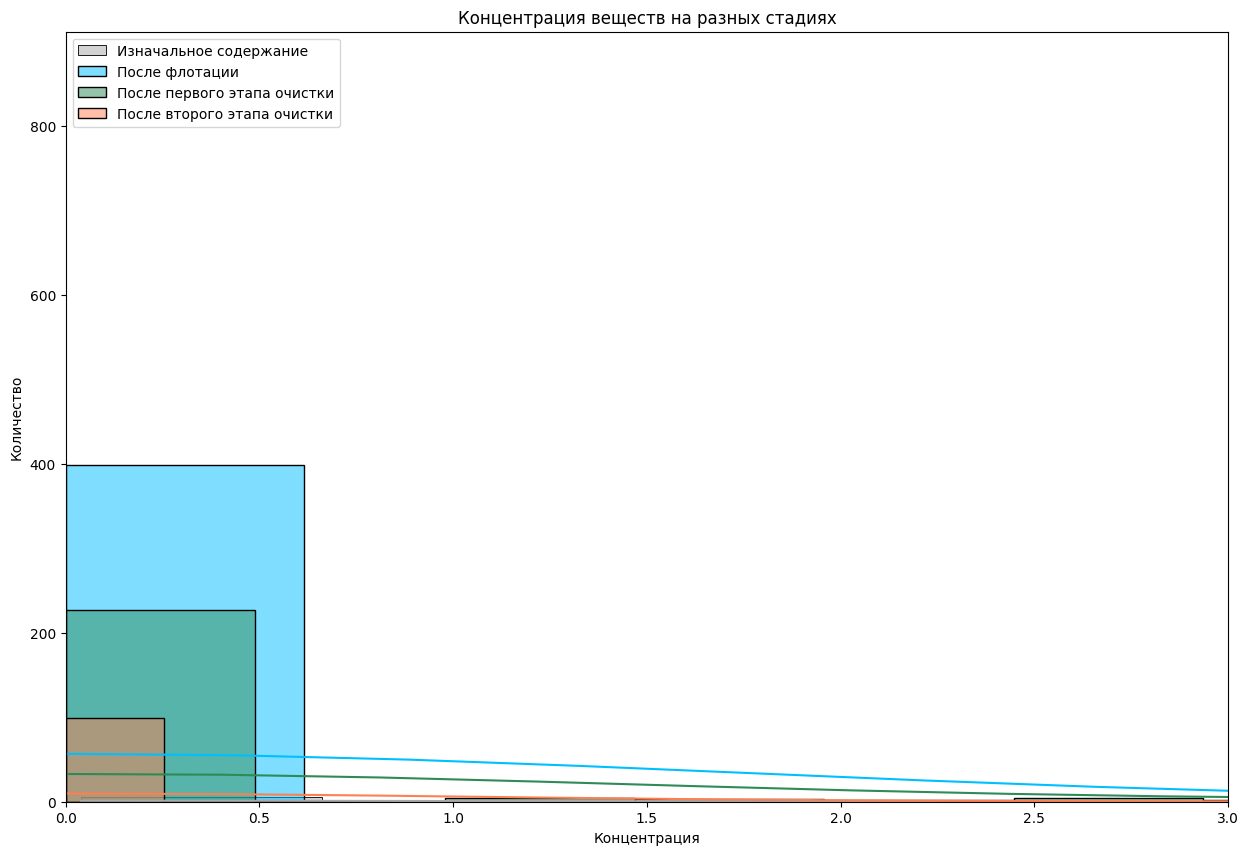

In [ ]:
plt.figure(figsize=(15, 10))

(sns.histplot(data=df_metall_conc, x='sum_feed', kde=True, color='darkgray', label='Изначальное содержание').
 set(title=('Концентрация веществ на разных стадиях'), xlabel='Концентрация', ylabel='Количество', xlim=(0, 3)))
sns.histplot(data=df_metall_conc, x='sum_rougher', kde=True, color='deepskyblue', label='После флотации')
sns.histplot(data=df_metall_conc, x='sum_first_cleaner', kde=True, color='seagreen',
             label='После первого этапа очистки')
sns.histplot(data=df_metall_conc, x='sum_final', kde=True, color='coral', label='После второго этапа очистки')

plt.legend(loc='upper left')
plt.show()

Удалим эти аномалии.

In [ ]:
df_train
df_train['sum_feed'] = (df_train['rougher.input.feed_au'] +
                              df_train['rougher.input.feed_ag'] +
                              df_train['rougher.input.feed_pb'] +
                              df_train['rougher.input.feed_sol'])
df_train['sum_rougher'] = (df_train['rougher.output.concentrate_au'] +
                              df_train['rougher.output.concentrate_ag'] +
                              df_train['rougher.output.concentrate_pb'] +
                              df_train['rougher.output.concentrate_sol'])
df_train['sum_first_cleaner'] = (df_train['primary_cleaner.output.concentrate_au'] +
                              df_train['primary_cleaner.output.concentrate_ag'] +
                              df_train['primary_cleaner.output.concentrate_pb'] +
                              df_train['primary_cleaner.output.concentrate_sol'])
df_train['sum_final'] = (df_train['final.output.concentrate_au'] +
                              df_train['final.output.concentrate_ag'] +
                              df_train['final.output.concentrate_pb'] +
                              df_train['final.output.concentrate_sol'])
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_feed,sum_rougher,sum_first_cleaner,sum_final
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842,51.680,66.425,72.641,63.644
2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498

In [ ]:
rows_to_drop_anomaly_train = df_train[(df_train['sum_feed'] < 1) |
                                      (df_train['sum_rougher'] < 1) |
                                      (df_train['sum_first_cleaner'] < 1) |
                                      (df_train['sum_final'] < 1)].index.to_list()

rows_to_drop_anomaly_train = [x for x in rows_to_drop_anomaly_train if x in df_train_upd.index.to_list()]

In [ ]:
df_train_upd.shape
df_train_upd = df_train_upd.drop(rows_to_drop_anomaly_train)
df_train_upd.shape

(13497, 36)

# Изучение моделей

##  Функции для вычисления итоговой sMAPE

In [ ]:
def smape(target, prediction):

    smape = 1 / len(target) * sum(abs(target - prediction) / ((abs(target) + abs(prediction)) * 0.5)) * 100
    return smape

In [ ]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
def smape_general(smape_rougher, smape_final):

    smape_general = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_general

##  Подготовка признаков для обучения

Подготовим признаки.

In [ ]:
features_train = df_train_upd.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = df_train_upd['rougher.output.recovery']
target_train_final = df_train_upd['final.output.recovery']

Отмасштабируем признаки.

In [ ]:
columns = features_train.columns.to_list()

scaler = StandardScaler()

scaler.fit(features_train[columns])

features_train[columns] = scaler.transform(features_train[columns])

display(features_train.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_level,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-0.191,0.369,-0.132,0.280,-0.300,-0.810,-0.436,0.054,-0.219,-1.319,-1.131,0.471,-0.206,0.096,0.070,0.105,-0.735,-0.350,1.847,0.249,0.159,0.052,-0.173,-0.940,-0.319,-0.147,-0.257,-0.478,-0.643,-0.760,-1.179,-0.385,-0.963,-2.711
2016-01-15 01:00:00,-0.229,0.419,-0.132,0.317,-0.357,-0.322,-0.241,0.126,-0.338,-1.287,-1.149,0.489,-0.126,-0.122,0.065,0.102,-0.732,-0.308,1.854,0.273,0.241,0.028,-0.174,-0.938,-0.407,-0.118,-0.260,-0.537,-0.671,-0.702,-1.160,-0.433,-0.990,-2.545
2016-01-15 02:00:00,-0.276,0.725,-0.132,0.287,-0.331,-0.344,-0.046,0.216,-0.357,-1.311,-1.247,0.536,-0.116,-0.077,0.049,0.286,-0.735,-0.308,1.851,0.273,0.257,0.029,-0.175,-0.948,-0.396,0.256,-0.271,-0.479,-0.678,-0.698,-1.154,-0.432,-0.984,-2.590
2016-01-15 03:00:00,-0.316,0.727,-0.132,0.301,-0.358,-0.316,-0.058,0.219,-0.362,-1.349,-1.360,0.662,-0.103,0.107,-0.043,0.292,-0.734,-0.309,1.841,0.270,0.255,0.041,-0.163,-0.939,-0.406,0.255,-0.272,-0.446,-0.662,-0.699,-1.172,-0.408,-0.988,-2.551
2016-01-15 04:00:00,-0.428,0.904,-0.132,0.336,-0.302,-0.335,-0.064,0.227,-0.374,-1.340,-1.592,0.641,-0.181,-0.413,-0.256,0.287,-0.735,-0.304,1.851,0.273,0.276,0.023,-0.163,-0.935,-0.407,0.256,-0.273,-0.426,-0.671,-0.697,-1.179,-0.473,-0.990,-2.592


## Модели

Используем следующие модели:
* LinearRegression
* ElasticNet
* DecisionTreeRegressor
* RandomForestRegressor
* CatBoostRegressor

### LinearRegression

Модель для rougher.

In [ ]:
model_lgr_r = LinearRegression()
smape_lgr_r = cross_val_score(model_lgr_r, features_train, target_train_rougher,
                             scoring=smape_scorer,
                             n_jobs=-1).mean()
smape_lgr_r = abs(smape_lgr_r)

Модель для final.

In [ ]:
model_lgr_f = LinearRegression()
smape_lgr_f = cross_val_score(model_lgr_f, features_train, target_train_final,
                              scoring=smape_scorer,
                              n_jobs=-1).mean()
smape_lgr_f = abs(smape_lgr_f)

Итоговая sMAPE.

In [ ]:
smape_lgr_general = smape_general(smape_lgr_r, smape_lgr_f)

In [ ]:
metrics = pd.Series(['Модель', 'sMAPE rougher', 'sMAPE final', 'sMAPE general']).rename('metrics')
lgr_metrics = pd.Series(['Линейная регрессия', smape_lgr_r, smape_lgr_f, smape_lgr_general]).rename('lgr')
df_metrics = pd.concat([metrics, lgr_metrics], axis=1)
df_metrics

,metrics,lgr
0,Модель,Линейная регрессия
1,sMAPE rougher,5.935
2,sMAPE final,9.855
3,sMAPE general,8.875


### ElasticNet

Модель для rougher.

In [ ]:
model_en_r = ElasticNet(random_state=RANDOM_STATE)

In [ ]:
alpha_en = list(np.arange(0.1, 1.1, 0.1))
l1_en = list(np.arange(0.1, 1.1, 0.1))
param_dis_en = {'alpha': alpha_en,
                 'l1_ratio': l1_en}

random_search_en_rougher = RandomizedSearchCV(estimator=model_en_r,
                                              param_distributions = param_dis_en,
                                              n_iter=10,
                                              n_jobs=-1,
                                              verbose=3,
                                              scoring=smape_scorer,
                                              random_state=RANDOM_STATE)
random_search_en_rougher.fit(features_train, target_train_rougher)

print('Лучшие параметры:', random_search_en_rougher.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'l1_ratio': 0.1, 'alpha': 0.30000000000000004}


In [ ]:
smape_en_r = abs(random_search_en_rougher.best_score_)

Модель для final.

In [ ]:
model_en_f = ElasticNet(random_state=RANDOM_STATE)

In [ ]:
random_search_en_final = RandomizedSearchCV(estimator=model_en_f,
                                            param_distributions = param_dis_en,
                                            n_iter=10,
                                            n_jobs=-1,
                                            verbose=3,
                                            scoring=smape_scorer,
                                            random_state=RANDOM_STATE)
random_search_en_final.fit(features_train, target_train_final)

print('Лучшие параметры:', random_search_en_final.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'l1_ratio': 0.7000000000000001, 'alpha': 0.9}


In [ ]:
smape_en_f = abs(random_search_en_final.best_score_)

Итоговая sMAPE.

In [ ]:
smape_en_general = smape_general(smape_en_r, smape_en_f)

In [ ]:
en_metrics = pd.Series(['Elastic Net', smape_en_r, smape_en_f, smape_en_general])
df_metrics['en'] = en_metrics
df_metrics.iloc[:, [0, 2]]

,metrics,en
0,Модель,Elastic Net
1,sMAPE rougher,5.996
2,sMAPE final,9.044
3,sMAPE general,8.282


### DecisionTreeRegressor

Модель для rougher.

In [ ]:
model_dtr_r = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [ ]:
max_depth_dtr = list(range(1, 51, 5))
param_dis_dtr = {'max_depth': max_depth_dtr}

random_search_dtr_rougher = RandomizedSearchCV(estimator=model_dtr_r,
                                               param_distributions = param_dis_dtr,
                                               n_iter=10,
                                               n_jobs=-1,
                                               verbose=3,
                                               scoring=smape_scorer,
                                               random_state=RANDOM_STATE)

random_search_dtr_rougher.fit(features_train, target_train_rougher)

print('Лучшие параметры:', random_search_dtr_rougher.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'max_depth': 6}


In [ ]:
smape_dtr_r = abs(random_search_dtr_rougher.best_score_)

Модель для final.

In [ ]:
model_dtr_f = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [ ]:
random_search_dtr_final = RandomizedSearchCV(estimator=model_dtr_f,
                                             param_distributions = param_dis_dtr,
                                             n_iter=10,
                                             n_jobs=-1,
                                             verbose=3,
                                             scoring=smape_scorer,
                                             random_state=RANDOM_STATE)

random_search_dtr_final.fit(features_train, target_train_final)

print('Лучшие параметры:', random_search_dtr_final.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'max_depth': 1}


In [ ]:
smape_dtr_f = abs(random_search_dtr_final.best_score_)

Итоговая sMAPE.

In [ ]:
smape_dtr_general = smape_general(smape_dtr_r, smape_dtr_f)

In [ ]:
dtr_metrics = pd.Series(['Дерево решений', smape_dtr_r, smape_dtr_f, smape_dtr_general])
df_metrics['dtr'] = dtr_metrics
df_metrics.iloc[:, [0, 3]]

,metrics,dtr
0,Модель,Дерево решений
1,sMAPE rougher,6.878
2,sMAPE final,9.299
3,sMAPE general,8.694


### RandomForestRegressor

Модель для rougher.

In [ ]:
model_rfr_r = RandomForestRegressor(random_state=RANDOM_STATE)

In [ ]:
max_depth_rfr = list(range(1, 51, 5))
n_estimators_rfr = list(range(1, 51, 5))
param_dis_rfr = {'max_depth': max_depth_rfr,
                   'n_estimators': n_estimators_rfr}

random_search_rfr_rougher = RandomizedSearchCV(estimator=model_rfr_r,
                                               param_distributions = param_dis_rfr,
                                               n_iter=10,
                                               n_jobs=-1,
                                               verbose=3,
                                               scoring=smape_scorer,
                                               random_state=RANDOM_STATE)
random_search_rfr_rougher.fit(features_train, target_train_rougher)

print('Лучшие параметры:', random_search_rfr_rougher.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'n_estimators': 46, 'max_depth': 31}


In [ ]:
smape_rfr_r = abs(random_search_rfr_rougher.best_score_)

Модель для final.

In [ ]:
model_rfr_f = RandomForestRegressor(random_state=RANDOM_STATE)

In [ ]:
random_search_rfr_final = RandomizedSearchCV(estimator=model_rfr_f,
                                             param_distributions = param_dis_rfr,
                                             n_iter=10,
                                             n_jobs=-1,
                                             verbose=3,
                                             scoring=smape_scorer,
                                             random_state=RANDOM_STATE)
random_search_rfr_final.fit(features_train, target_train_final)

print('Лучшие параметры:', random_search_rfr_final.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'n_estimators': 26, 'max_depth': 16}


In [ ]:
smape_rfr_f = abs(random_search_rfr_final.best_score_)

Итоговая sMAPE.

In [ ]:
smape_rfr_general = smape_general(smape_rfr_r, smape_rfr_f)

In [ ]:
rfr_metrics = pd.Series(['Случайный лес', smape_rfr_r, smape_rfr_f, smape_rfr_general])
df_metrics['rfr'] = rfr_metrics
df_metrics.iloc[:, [0, 4]]

,metrics,rfr
0,Модель,Случайный лес
1,sMAPE rougher,6.589
2,sMAPE final,9.564
3,sMAPE general,8.820


### CatBoostRegressor

Модель для rougher.

In [ ]:
model_cbr_r = CatBoostRegressor(random_state=RANDOM_STATE, depth=10, eval_metric='SMAPE')

In [ ]:
grid_params_cbr = {'learning_rate' : [0.01, 0.05, 0.1]}

grid_search_cbr_rougher = GridSearchCV(estimator=model_cbr_r,
                                       param_grid = grid_params_cbr,
                                       n_jobs=-1,
                                       verbose=3,
                                       scoring=make_scorer(smape))
grid_search_cbr_rougher.fit(features_train, target_train_rougher)

print('Лучшие параметры:', grid_search_cbr_rougher.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 6.7604360	total: 156ms	remaining: 2m 35s
1:	learn: 6.3405014	total: 260ms	remaining: 2m 9s
2:	learn: 5.9734764	total: 374ms	remaining: 2m 4s
3:	learn: 5.6395557	total: 475ms	remaining: 1m 58s
4:	learn: 5.3678170	total: 582ms	remaining: 1m 55s
5:	learn: 5.1060281	total: 691ms	remaining: 1m 54s
6:	learn: 4.8722001	total: 823ms	remaining: 1m 56s
7:	learn: 4.6667811	total: 928ms	remaining: 1m 55s
8:	learn: 4.4823543	total: 1.04s	remaining: 1m 54s
9:	learn: 4.3255172	total: 1.13s	remaining: 1m 52s
10:	learn: 4.1892739	total: 1.23s	remaining: 1m 50s
11:	learn: 4.0625934	total: 1.33s	remaining: 1m 49s
12:	learn: 3.9624526	total: 1.43s	remaining: 1m 48s
13:	learn: 3.8636834	total: 1.53s	remaining: 1m 47s
14:	learn: 3.7759897	total: 1.63s	remaining: 1m 47s
15:	learn: 3.7014180	total: 1.72s	remaining: 1m 46s
16:	learn: 3.6264137	total: 1.83s	remaining: 1m 45s
17:	learn: 3.5633495	total: 1.94s	remaining: 1m 45s
18:	learn: 3.518

In [ ]:
smape_cbr_r = grid_search_cbr_rougher.best_score_

Модель для final.

In [ ]:
model_cbr_f = CatBoostRegressor(random_state=RANDOM_STATE, depth=10, eval_metric='SMAPE')

In [ ]:
grid_search_cbr_final = GridSearchCV(estimator=model_cbr_f,
                                   param_grid = grid_params_cbr,
                                   n_jobs=-1,
                                   verbose=3,
                                   scoring=make_scorer(smape))
grid_search_cbr_final.fit(features_train, target_train_final)

print('Лучшие параметры:', grid_search_cbr_final.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 9.4390490	total: 197ms	remaining: 3m 16s
1:	learn: 9.0841113	total: 382ms	remaining: 3m 10s
2:	learn: 8.7720059	total: 570ms	remaining: 3m 9s
3:	learn: 8.4764649	total: 759ms	remaining: 3m 8s
4:	learn: 8.2236647	total: 947ms	remaining: 3m 8s
5:	learn: 8.0018065	total: 1.05s	remaining: 2m 53s
6:	learn: 7.7775864	total: 1.14s	remaining: 2m 42s
7:	learn: 7.5962605	total: 1.25s	remaining: 2m 34s
8:	learn: 7.4392857	total: 1.34s	remaining: 2m 27s
9:	learn: 7.3028163	total: 1.43s	remaining: 2m 21s
10:	learn: 7.1787796	total: 1.53s	remaining: 2m 18s
11:	learn: 7.0710521	total: 1.63s	remaining: 2m 14s
12:	learn: 6.9604914	total: 1.72s	remaining: 2m 10s
13:	learn: 6.8644018	total: 1.83s	remaining: 2m 9s
14:	learn: 6.7857526	total: 1.93s	remaining: 2m 6s
15:	learn: 6.7174322	total: 2.02s	remaining: 2m 4s
16:	learn: 6.6164137	total: 2.13s	remaining: 2m 3s
17:	learn: 6.5565495	total: 2.22s	remaining: 2m 1s
18:	learn: 6.5016604	t

In [ ]:
smape_cbr_f = grid_search_cbr_final.best_score_

Итоговая sMAPE.

In [ ]:
smape_cbr_general = smape_general(smape_cbr_r, smape_cbr_f)

In [ ]:
cbr_metrics = pd.Series(['CatBoostRegressor', smape_cbr_r, smape_cbr_f, smape_cbr_general])
df_metrics['cbr'] = cbr_metrics
df_metrics.iloc[:, [0, 5]]

,metrics,cbr
0,Модель,CatBoostRegressor
1,sMAPE rougher,5.852
2,sMAPE final,8.773
3,sMAPE general,8.043


### Вывод

In [ ]:
df_metrics

,metrics,lgr,en,dtr,rfr,cbr
0,Модель,Линейная регрессия,Elastic Net,Дерево решений,Случайный лес,CatBoostRegressor
1,sMAPE rougher,5.935,5.996,6.878,6.589,5.852
2,sMAPE final,9.855,9.044,9.299,9.564,8.773
3,sMAPE general,8.875,8.282,8.694,8.820,8.043


Лучшую метрику sMAPE выдает модель CatBoostRegressor, с гиперпараметром 'learning_rate' равным 0.1

## Проверка на тестовых данных

Подготовим признаки.

In [ ]:
features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

Отмасштабируем признаки.

In [ ]:
columns = features_test.columns.to_list()

scaler = StandardScaler()

scaler.fit(features_test[columns])

features_test[columns] = scaler.transform(features_test[columns])

display(features_test.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_level,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,0.837,2.078,1.333,-0.593,-0.144,0.010,-1.087,-1.246,0.019,1.953,1.927,-0.004,0.358,0.789,0.915,-0.313,-0.436,0.499,-0.093,1.608,1.177,0.076,-1.627,-0.830,1.207,-1.044,1.283,0.234,-1.678,-0.445,-1.617,4.195,2.076,0.050
2016-09-01 01:59:59,0.944,2.076,1.333,-0.616,-0.135,0.014,-1.120,-1.241,-0.011,1.904,1.811,-0.001,0.318,0.637,0.939,-0.461,-0.462,0.498,-0.081,1.598,1.178,0.100,-1.631,-0.834,1.213,-1.028,1.278,0.205,-1.644,-0.426,-1.613,-1.506,1.703,0.047
2016-09-01 02:59:59,0.941,1.383,0.853,-0.607,-0.179,0.015,-1.104,-1.242,0.012,1.958,1.707,-0.006,0.578,0.885,0.936,-0.604,-0.463,0.505,-0.085,1.580,1.182,0.082,-1.616,-0.827,1.210,-1.030,1.287,0.202,-1.654,-0.440,-1.576,0.020,1.697,0.026
2016-09-01 03:59:59,0.943,1.094,0.612,-0.814,-0.071,0.032,-1.086,-1.228,-0.032,1.573,1.380,-0.127,0.208,0.613,0.798,-0.650,-0.449,0.501,-0.087,1.650,1.162,0.115,-1.635,-0.828,1.228,-1.040,1.290,0.216,-1.661,-0.424,-1.633,0.016,1.687,0.076
2016-09-01 04:59:59,0.562,0.657,0.432,-0.904,-0.175,0.023,-1.069,-1.242,0.023,1.015,1.015,-0.018,0.390,0.651,-0.078,-0.712,-0.480,0.496,0.180,1.578,1.186,0.116,-1.620,-0.839,1.202,-1.041,1.279,0.137,-1.667,-0.435,-1.563,-0.512,1.699,0.020


### Финальная модель - CatBoostRegressor

Обучим модель.

Модель для rougher.

In [ ]:
final_model_cbr_r = CatBoostRegressor(learning_rate=0.1, depth=10, random_state=RANDOM_STATE, eval_metric='SMAPE')

In [ ]:
final_model_cbr_r.fit(features_test, target_test_rougher)
prediction_cbr_r = final_model_cbr_r.predict(features_test)

0:	learn: 8.3999525	total: 99.7ms	remaining: 1m 39s
1:	learn: 8.1872974	total: 187ms	remaining: 1m 33s
2:	learn: 7.9775374	total: 281ms	remaining: 1m 33s
3:	learn: 7.8311426	total: 383ms	remaining: 1m 35s
4:	learn: 7.6533275	total: 487ms	remaining: 1m 36s
5:	learn: 7.5216812	total: 600ms	remaining: 1m 39s
6:	learn: 7.4013930	total: 692ms	remaining: 1m 38s
7:	learn: 7.3120763	total: 796ms	remaining: 1m 38s
8:	learn: 7.2195402	total: 901ms	remaining: 1m 39s
9:	learn: 7.1174282	total: 1.01s	remaining: 1m 39s
10:	learn: 7.0299478	total: 1.09s	remaining: 1m 38s
11:	learn: 6.9846329	total: 1.19s	remaining: 1m 38s
12:	learn: 6.9037719	total: 1.29s	remaining: 1m 37s
13:	learn: 6.8422958	total: 1.38s	remaining: 1m 37s
14:	learn: 6.7905219	total: 1.48s	remaining: 1m 37s
15:	learn: 6.7270439	total: 1.58s	remaining: 1m 37s
16:	learn: 6.6733544	total: 1.67s	remaining: 1m 36s
17:	learn: 6.6383200	total: 1.78s	remaining: 1m 37s
18:	learn: 6.5953302	total: 1.86s	remaining: 1m 36s
19:	learn: 6.5653386	

In [ ]:
final_smape_cbr_r = smape(target_test_rougher, prediction_cbr_r)

Модель для final.

In [ ]:
final_model_cbr_f = CatBoostRegressor(learning_rate=0.1, depth=10, random_state=RANDOM_STATE, eval_metric='SMAPE')

In [ ]:
final_model_cbr_f.fit(features_test, target_test_final)
prediction_cbr_f = final_model_cbr_f.predict(features_test)

0:	learn: 8.9013130	total: 99.8ms	remaining: 1m 39s
1:	learn: 8.7301800	total: 190ms	remaining: 1m 34s
2:	learn: 8.5599729	total: 288ms	remaining: 1m 35s
3:	learn: 8.4173071	total: 380ms	remaining: 1m 34s
4:	learn: 8.2958799	total: 478ms	remaining: 1m 35s
5:	learn: 8.1529399	total: 589ms	remaining: 1m 37s
6:	learn: 8.0426801	total: 683ms	remaining: 1m 36s
7:	learn: 7.9531818	total: 774ms	remaining: 1m 35s
8:	learn: 7.8395722	total: 880ms	remaining: 1m 36s
9:	learn: 7.7527049	total: 973ms	remaining: 1m 36s
10:	learn: 7.6890019	total: 1.11s	remaining: 1m 39s
11:	learn: 7.6070941	total: 1.2s	remaining: 1m 38s
12:	learn: 7.5623767	total: 1.3s	remaining: 1m 38s
13:	learn: 7.4651160	total: 1.4s	remaining: 1m 38s
14:	learn: 7.3896950	total: 1.5s	remaining: 1m 38s
15:	learn: 7.3444286	total: 1.59s	remaining: 1m 37s
16:	learn: 7.2893266	total: 1.7s	remaining: 1m 38s
17:	learn: 7.2536631	total: 1.79s	remaining: 1m 37s
18:	learn: 7.2234155	total: 1.9s	remaining: 1m 37s
19:	learn: 7.1821898	total:

In [ ]:
final_smape_cbr_f = smape(target_test_final, prediction_cbr_f)

Итоговая sMAPE.

In [ ]:
final_smape_cbr_general = smape_general(final_smape_cbr_r, final_smape_cbr_f)

In [ ]:
final_cbr_metrics = (pd.Series(['CatBoostRegressor', final_smape_cbr_r, final_smape_cbr_f, final_smape_cbr_general]).
                     rename('cbr'))
df_metrics_final = pd.concat([metrics, final_cbr_metrics], axis=1)
df_metrics_final

,metrics,cbr
0,Модель,CatBoostRegressor
1,sMAPE rougher,3.719
2,sMAPE final,1.459
3,sMAPE general,2.024


### Константная модель

Обучим модель.

Модель для rougher.

In [ ]:
dummy_model_r = DummyRegressor(strategy='median')

In [ ]:
dummy_model_r.fit(features_test, target_test_rougher)
prediction_dummy_r = dummy_model_r.predict(features_test)

In [ ]:
dummy_smape_r = smape(target_test_rougher, prediction_dummy_r)

Модель для final.

In [ ]:
dummy_model_f = DummyRegressor(strategy='median')

In [ ]:
dummy_model_f.fit(features_test, target_test_final)
prediction_dummy_f = dummy_model_f.predict(features_test)

In [ ]:
dummy_smape_f = smape(target_test_rougher, prediction_dummy_f)

Итоговая sMAPE.

In [ ]:
dummy_smape_general = smape_general(dummy_smape_r, dummy_smape_f)

In [ ]:
dummy_metrics = pd.Series(['DummyRegressor', dummy_smape_r, dummy_smape_f, dummy_smape_general])
df_metrics_final['dr'] = dummy_metrics
df_metrics_final.iloc[:, [0,2]]

,metrics,dr
0,Модель,DummyRegressor
1,sMAPE rougher,7.948
2,sMAPE final,25.032
3,sMAPE general,20.761


### Вывод

In [ ]:
df_metrics_final

,metrics,cbr,dr
0,Модель,CatBoostRegressor,DummyRegressor
1,sMAPE rougher,3.719,7.948
2,sMAPE final,1.459,25.032
3,sMAPE general,2.024,20.761


1. Выбраная лучшая модель имеет итоговый показатель sMAPE = 2.024, на 18 лучше чем константная модель.
2. Выбранная модель - адекватна.

# Вывод

1. Загружены и изучены полученные данные.
2. Выполнена подготовка данных.
    * Выполнена проверка правильности расчет эффективности обогащения с положительным результатом.
    * Были проанализированы признаки отсутствующие в тестовой выборке, данные прихнаки были удалены из обучающий выборки.
    * В тестовую выборку были добавленые целевые признаки.
    * Выполнена предобработка данных:
        * Выполнена проверка на дубликаты с отрицательным результатом;
        * Отобраны признаки с сильной корреляцуией и удалены лишние для облегчения модели;
        * Обработаны пропуски.
3. Выполнен анализ данных.
    * Изучено изменение концентрация Au, Ag, Pb на разных стадиях очистки и их зависимости.
    * Выполнено сравнение распределения размеров гранул сырья на обучающей и тестовой выборке, по результатам, возможно дальнейшее построение моделей из-за схожести распределений.
    * Исследована суммарная концентрация веществ на разных этапах, найдены и удалены аномальные значения.
4. Выполнено изучение моделей.
    * Написаны функции для вычисления основной метрики sMAPE.
    * Подготовлены и отмасштабированы выборки.
    * Рассмотрены следующие модели:
        * LinearRegression;
        * ElasticNet;
        * DecisionTreeRegressor;
        * RandomForestRegressor;
        * CatBoostRegressor.
    * Модели обучены с помощью кросс валидации, подобраны гиперпараметры.
    * Лучшая модель CatBoostRegressor(learning_rate=0.1) как для признака <code>rougher.output.recovery</code>, так и для <code>final.output.recovery</code>.
5. Выполнена проверка модели на тестовый выборке.
    * Модель показала очень хороший результат на тестовый выборке.
    * Проведено сравнение с константной моделью. У выбранной модели метрика sMAPE на 17 лучше, модель адекватна.